# Markov Chains and Hidden Markov Models  

### George Tzanetakis, University of Victoria 

In this notebook we will explore hidden markov models. We start with random variables and a simple independent, identically distributed model for weather. Then we look into how to form a Markov Chain to transition between states and finally we sample a Hidden Markov Model to show how the samples are generated based on the Markov Chain of the hidden states. The results are visualized as strips of colored rectangles. Experiment with the transition probabilities and the emission probabilities to gain a better understanding of how Hidden Markov Models work in terms of generating data. 


In [1]:
%matplotlib inline 
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
from hmmlearn import hmm



In [2]:
class Random_Variable: 
    
    def __init__(self, name, values, probability_distribution): 
        self.name = name 
        self.values = values 
        self.probability_distribution = probability_distribution 
        if all(type(item) is np.int64 for item in values): 
            self.type = 'numeric'
            self.rv = stats.rv_discrete(name = name, values = (values, probability_distribution))
        elif all(type(item) is str for item in values): 
            self.type = 'symbolic'
            self.rv = stats.rv_discrete(name = name, values = (np.arange(len(values)), probability_distribution))
            self.symbolic_values = values 
        else: 
            self.type = 'undefined'
            
    def sample(self,size): 
        if (self.type =='numeric'): 
            return self.rv.rvs(size=size)
        elif (self.type == 'symbolic'): 
            numeric_samples = self.rv.rvs(size=size)
            mapped_samples = [self.values[x] for x in numeric_samples]
            return mapped_samples 
        
    def probs(self): 
        return self.probability_distribution
    
    def vals(self): 
        print(self.type)
        return self.values 
            
        

Let's first create some random samples of a symbolic random variable corresponding to the weather with two values Sunny (S) and cloudy (C) and generate random weather for 365 days. The assumption in this model is that the weather of each day is indepedent of the previous days and drawn from the same probability distribution. 

In [3]:
values = ['S', 'C']
probabilities = [0.5, 0.5]
weather = Random_Variable('weather', values, probabilities)
samples = weather.sample(365)

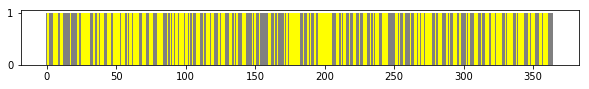

In [4]:
state2color = {} 
state2color['S'] = 'yellow'
state2color['C'] = 'grey'

def plot_weather_samples(samples, state2color): 
    colors = [state2color[x] for x in samples]
    x = np.arange(0, len(colors))
    y = np.ones(len(colors))
    plt.figure(figsize=(10,1))
    plt.bar(x, y, color=colors, width=1)
    
plot_weather_samples(samples, state2color)


Now instead of independently sampling the weather random variable lets form a markov chain. 

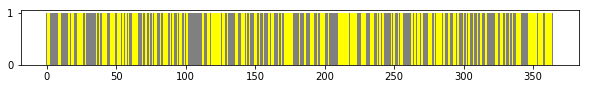

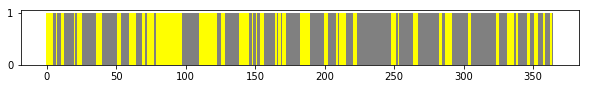

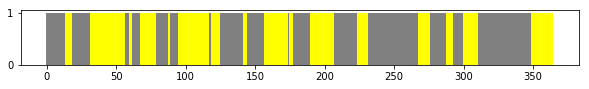

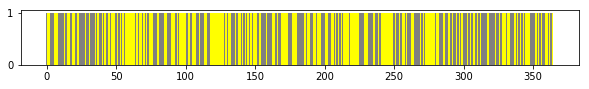

In [6]:
def markov_chain(transmat, state, state_names, samples): 
    (rows, cols) = transmat.shape 
    rvs = [] 
    values = list(np.arange(0,rows))
    
    # create random variables for each row of transition matrix 
    for r in range(rows): 
        rv = Random_Variable("row" + str(r), values, transmat[r])
        rvs.append(rv)
    
    # start from initial state and then sample the appropriate 
    # random variable based on the state following the transitions 
    states = [] 
    for n in range(samples): 
        state = rvs[state].sample(1)[0]    
        states.append(state_names[state])
    return states


# transition matrices for the Markov Chain 
transmat1 = np.array([[0.7, 0.3], 
                    [0.2, 0.8]])

transmat2 = np.array([[0.9, 0.1], 
                    [0.1, 0.9]])

transmat3 = np.array([[0.5, 0.5], 
                     [0.5, 0.5]])



# plot the iid model too

state2color = {} 
state2color['S'] = 'yellow'
state2color['C'] = 'grey'
samples = weather.sample(365)

plot_weather_samples(samples, state2color)

samples1 = markov_chain(transmat1,0,['S','C'], 365)
plot_weather_samples(samples1, state2color)

samples2 = markov_chain(transmat2,0,['S','C'], 365)
plot_weather_samples(samples2, state2color)

samples3 = markov_chain(transmat3,0,['S','C'], 365)
plot_weather_samples(samples3, state2color)




Lets now look at how a Hidden Markov Model would work by having a Markov Chain to generate 
a sequence of states and for each state having a different emission probability. When sunny we will output red or yellow with higher probabilities and when cloudy black or blue. First we will write the code directly and then we will use the hmmlearn package. 


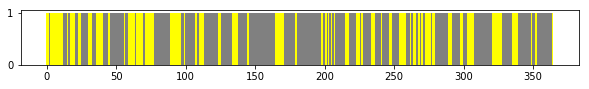

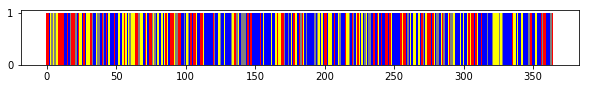

In [7]:
state2color = {} 
state2color['S'] = 'yellow'
state2color['C'] = 'grey'

samples = weather.sample(365)
states = markov_chain(transmat1,0,['S','C'], 365)
plot_weather_samples(states, state2color)

sunny_colors = Random_Variable('sunny_colors', ['y', 'r', 'b', 'g'], 
                              [0.4, 0.4, 0.1, 0.1])
cloudy_colors = Random_Variable('cloudy_colors', ['y', 'r', 'b', 'g'], 
                               [0.1, 0.1, 0.6, 0.2])

def emit_sample(state, sunny_colors, cloudy_colors): 
    if (state == 'S'): 
        sample = sunny_colors.sample(1)[0]
    else: 
        sample = cloudy_colors.sample(1)[0]
    return sample 

samples = [emit_sample(s, sunny_colors, cloudy_colors) for s in states]
state2color = {} 
state2color['y'] = 'yellow'
state2color['r'] = 'red'
state2color['b'] = 'blue'
state2color['g'] = 'grey'
plot_weather_samples(samples, state2color)





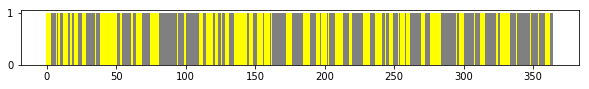

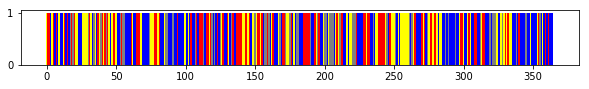

In [8]:
transmat = np.array([[0.7, 0.3], 
                    [0.2, 0.8]])

start_prob = np.array([1.0, 0.0, 0.0])

# yellow and red have high probs for sunny 
# blue and grey have high probs for cloudy 
emission_probs = np.array([[0.4, 0.4, 0.1, 0.1], 
                           [0.1, 0.1, 0.6, 0.2]])

model = hmm.MultinomialHMM(n_components=2)
model.startprob_ = start_prob 
model.transmat_ = transmat 
model.emissionprob_ = emission_probs

# sample the model - X is the observed values 
# and Z is the "hidden" states 
X, Z = model.sample(365)

state2color = {} 
state2color[0] = 'yellow'
state2color[1] = 'grey'
plot_weather_samples(Z, state2color)

samples = [item for sublist in X for item in sublist]
state2color = {} 
state2color[0] = 'yellow'
state2color[1] = 'red'
state2color[2] = 'blue'
state2color[3] = 'grey'
plot_weather_samples(samples, state2color)








Let's sample the generative HMM and get a sequence of observations. Now we can learn in an unsupervised way the paraemters of a two component multinomial HMM. Then we can compare the learned parameters with the original parameters. Notice that the order of the components is different between the original and estimated models. Notice that hmmlearn does NOT support supervised training directly where you have both the labels and observations. It is possible to initialize a HMM model with some parameters and learn the others. For example you can initialize the transition matrix and learn the emission probabilities. That way you could implement supervised learning for a multinomial HMM. In many practical applications the hidden labels are not available. 


In [9]:
X, Z = model.sample(1000)
estimated_model = hmm.MultinomialHMM(n_components=2, n_iter=10000).fit(X)


In [10]:
print("Transition matrix")
print("Estimated model:")
print(estimated_model.transmat_)
print("Original model:")
print(model.transmat_)
print("Emission probabilities")
print("Estimated model")
print(estimated_model.emissionprob_)
print("Original model")
print(model.emissionprob_)

Transition matrix
Estimated model:
[[ 0.49875456  0.50124544]
 [ 0.48243088  0.51756912]]
Original model:
[[ 0.7  0.3]
 [ 0.2  0.8]]
Emission probabilities
Estimated model
[[ 0.27329191  0.22042246  0.42386461  0.08242102]
 [ 0.14110042  0.20584142  0.44377507  0.2092831 ]]
Original model
[[ 0.4  0.4  0.1  0.1]
 [ 0.1  0.1  0.6  0.2]]


We can also use the trained HMM model to predict a sequence of hidden states given a sequence of observations. This is the tasks of maximum likelihood sequence estimation and for example in Speech Recognition would correspond to estimating a sequence of phonemes (hidden states) from a sequence of observations (acoustic vectors). 


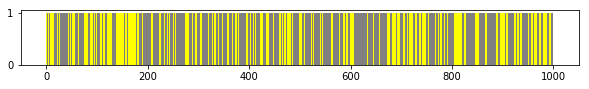

In [9]:
Z2 = estimated_model.predict(X)
state2color = {} 
state2color[0] = 'yellow'
state2color[1] = 'grey'
plot_weather_samples(Z, state2color)


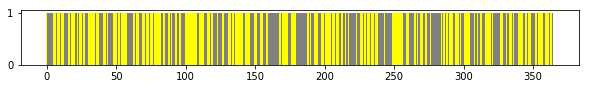

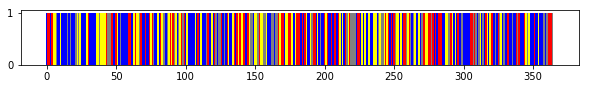

In [39]:
X, Z = estimated_model.sample(365)

state2color = {} 
state2color[0] = 'yellow'
state2color[1] = 'grey'
plot_weather_samples(Z, state2color)

samples = [item for sublist in X for item in sublist]
state2color = {} 
state2color[0] = 'yellow'
state2color[1] = 'red'
state2color[2] = 'blue'
state2color[3] = 'grey'
plot_weather_samples(samples, state2color)



Let's do pretend music example by having the states model a chord progression consisting of D (II), G(V), C (I) chords and the observations consist of chord type i.e whether they are minor7, major7, or dominant7. 

In [11]:

# probabities of each state D(II), G(V), C(I). The transitions are semi-plausible but set by hand. 
# in a full problem they would be learned from data 
transmat = np.array([[0.4, 0.4, 0.2], 
                    [0.1, 0.1, 0.8], 
                    [0.0, 0.3, 0.7]])

start_prob = np.array([1.0, 0.0, 0.0])

# the emission probabilities are also set by hand and semi-plausible and correspond 
# to the probability that a chord is dominant, minor or major 7th. Notice for example 
# that if the chord is a C(I) (the third row then it will never be a dominant chord the 
# last 0.0 in that row 
emission_probs = np.array([[0.4, 0.0, 0.4], 
                           [0.3, 0.3, 0.3],
                           [0.2, 0.8, 0.0]]) 
                          

chord_model = hmm.MultinomialHMM(n_components=2)
chord_model.startprob_ = start_prob 
chord_model.transmat_ = transmat 
chord_model.emissionprob_ = emission_probs

X, Z = chord_model.sample(10)
print(X,Z)

state2name = {} 
state2name[0] = 'D'
state2name[1] = 'G'
state2name[2] = 'C'
chords = [state2name[state] for state in Z]
print(chords)

obj2name = {}
obj2name[0] = 'min7'
obj2name[1] = 'maj7'
obj2name[2] = '7'
observations = [obj2name[item] for sublist in X for item in sublist]
print(observations)

chords = [''.join(chord) for chord in zip(chords,observations)]
print(chords)

[[0]
 [0]
 [2]
 [0]
 [0]
 [2]
 [1]
 [1]
 [0]
 [0]] [0 1 0 0 0 1 2 2 1 1]
['D', 'G', 'D', 'D', 'D', 'G', 'C', 'C', 'G', 'G']
['min7', 'min7', '7', 'min7', 'min7', '7', 'maj7', 'maj7', 'min7', 'min7']
['Dmin7', 'Gmin7', 'D7', 'Dmin7', 'Dmin7', 'G7', 'Cmaj7', 'Cmaj7', 'Gmin7', 'Gmin7']


In [12]:
from music21 import *

# create some chords for II, V, I 
d7 = chord.Chord(['D4','F4', 'A4', 'C5'])
dmin7 = chord.Chord(['D4','F-4', 'A4', 'C5'])
dmaj7 = chord.Chord(['D4','F#4', 'A4', 'C#5'])

c7 = d7.transpose(-2)
cmin7 = dmin7.transpose(-2)
cmaj7 = dmaj7.transpose(-2)

g7 = d7.transpose(5)
gmin7 = dmin7.transpose(5)
gmaj7 = dmaj7.transpose(5)
print(g7.pitches)

stream1 = stream.Stream()
stream1.repeatAppend(dmin7,1)
stream1.repeatAppend(g7,1)
stream1.repeatAppend(cmaj7,1)
stream1.repeatAppend(cmaj7,1)
print(stream1)

name2chord = {} 
name2chord['C7'] = c7 
name2chord['Cmin7'] = cmin7 
name2chord['Cmaj7'] = cmaj7

name2chord['D7'] = d7 
name2chord['Dmin7'] = dmin7 
name2chord['Dmaj7'] = dmaj7

name2chord['G7'] = g7 
name2chord['Gmin7'] = gmin7 
name2chord['Gmaj7'] = gmaj7


markov_chords = stream.Stream() 
for c in chords: 
    markov_chords.repeatAppend(name2chord[c],1)




(<music21.pitch.Pitch G4>, <music21.pitch.Pitch B-4>, <music21.pitch.Pitch D5>, <music21.pitch.Pitch F5>)
<music21.stream.Stream 0x10cbcdc88>


In [13]:
# let's check that we can play streams of chords 
sp = midi.realtime.StreamPlayer(stream1)
sp.play()

In [14]:
# let's now play a hidden markov model generated chord sequence
print(chords)
sp = midi.realtime.StreamPlayer(markov_chords)
sp.play()

['Dmin7', 'Gmin7', 'D7', 'Dmin7', 'Dmin7', 'G7', 'Cmaj7', 'Cmaj7', 'Gmin7', 'Gmin7']


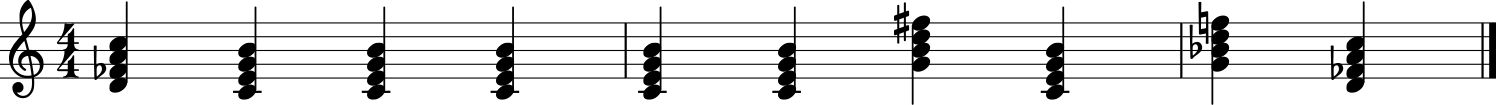

In [92]:
markov_chords.show()
